In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [2]:
def load_split(path):
    return pd.read_csv(path)

In [3]:
def plot_class_distribution(df, title):
    """
    Plots spam vs ham distribution.
    """
    counts = df["label"].value_counts().sort_index()

    plt.figure()
    plt.bar(["Ham", "Spam"], counts.values)
    plt.xlabel("Class")
    plt.ylabel("Number of Messages")
    plt.title(title)
    plt.show()


In [4]:
train_df = load_split("train.csv")
val_df = load_split("validation.csv")
test_df = load_split("test.csv")

In [5]:
train_df

,label,text
0,1,goal arsenal 4 henry 7 v liverpool 2 henry sco...
1,0,they said if its gonna snow it will start arou...
2,0,aah bless hows your arm
3,0,oh k i will come tomorrow
4,0,whats happening with you have you gotten a job...
...,...,...
3895,0,good morning pookie pie lol hope i didnt wake ...
3896,0,take care n get well soon
3897,0,hurry up ive been weeddeficient for like three...
3898,0,we are at grandmas oh dear u still ill i felt ...


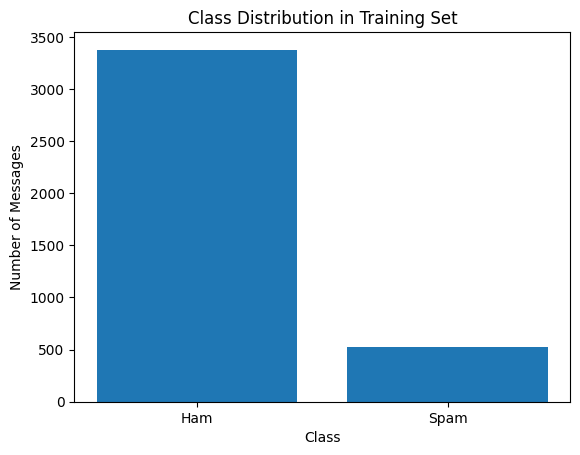

In [6]:
plot_class_distribution(train_df, "Class Distribution in Training Set")


* The dataset exhibits significant class imbalance, with spam messages forming approximately 13% of the data. To address this, stratified data splits were used.

In [7]:
train_df.isna().sum()

label    0
text     1
dtype: int64

In [8]:
def clean_nan_rows(df):
    df = df.dropna(subset=["text"])
    df = df[df["text"].str.strip() != ""]
    return df

In [9]:
train_df = clean_nan_rows(train_df)
val_df = clean_nan_rows(val_df)
test_df = clean_nan_rows(test_df)

In [10]:
def vectorize_text(train_texts, val_texts=None, test_texts=None):
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=5000
    )

    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts) if val_texts is not None else None
    X_test = vectorizer.transform(test_texts) if test_texts is not None else None

    return vectorizer, X_train, X_val, X_test

In [11]:
def fit_model(model, X, y):
    model.fit(X, y)
    return model

In [12]:
def score_model(model, X, y):
    preds = model.predict(X)
    return accuracy_score(y, preds)

In [13]:
def evaluate_model(model, X, y):
    preds = model.predict(X)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, preds, average="binary"
    )
    accuracy = accuracy_score(y, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [14]:
X_train_text = train_df["text"]
y_train = train_df["label"]

X_val_text = val_df["text"]
y_val = val_df["label"]

vectorizer, X_train, X_val, _ = vectorize_text(
    X_train_text,
    X_val_text
)


In [15]:
models = {
    "NaiveBayes": MultinomialNB(alpha=0.5),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "LinearSVM": LinearSVC(C=0.1,  class_weight="balanced")
}

* Class-weighted loss functions were applied for linear models due to class imbalance.

In [16]:
results = {}

for name, model in models.items():
    model = fit_model(model, X_train, y_train)

    train_metrics = evaluate_model(model, X_train, y_train)
    val_metrics = evaluate_model(model, X_val, y_val)

    results[name] = {
        "train": train_metrics,
        "validation": val_metrics
    }

results

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'NaiveBayes': {'train': {'accuracy': 0.9894844832008207,
   'precision': 0.9958847736625515,
   'recall': 0.9254302103250478,
   'f1': 0.9593657086223984},
  'validation': {'accuracy': 0.9772455089820359,
   'precision': 1.0,
   'recall': 0.8303571428571429,
   'f1': 0.9073170731707317}},
 'LogisticRegression': {'train': {'accuracy': 0.9915362913567581,
   'precision': 0.9454545454545454,
   'recall': 0.994263862332696,
   'f1': 0.9692451071761418},
  'validation': {'accuracy': 0.9820359281437125,
   'precision': 0.944954128440367,
   'recall': 0.9196428571428571,
   'f1': 0.9321266968325792}},
 'LinearSVM': {'train': {'accuracy': 0.992818671454219,
   'precision': 0.9524680073126143,
   'recall': 0.9961759082217974,
   'f1': 0.9738317757009346},
  'validation': {'accuracy': 0.9832335329341317,
   'precision': 0.9537037037037037,
   'recall': 0.9196428571428571,
   'f1': 0.9363636363636363}}}

* F1 score, precision, and recall are more important than accuracy

In [17]:
from copy import deepcopy

In [18]:
def tune_hyperparameter(
    model_class,
    param_name,
    param_values,
    X_train,
    y_train,
    X_val,
    y_val,
    fixed_params=None
):
    """
    Tunes a single hyperparameter using validation F1 score.
    """
    best_f1 = -1
    best_model = None
    best_param = None

    fixed_params = fixed_params or {}

    for val in param_values:
        params = deepcopy(fixed_params)
        params[param_name] = val

        model = model_class(**params)
        model.fit(X_train, y_train)

        metrics = evaluate_model(model, X_val, y_val)

        if metrics["f1"] > best_f1:
            best_f1 = metrics["f1"]
            best_model = model
            best_param = val

    return best_model, best_param, best_f1


In [19]:
lr_param_values = [0.01, 0.05, 0.1, 0.5, 1]

best_lr, best_C_lr, best_f1_lr = tune_hyperparameter(
    model_class=LogisticRegression,
    param_name="C",
    param_values=lr_param_values,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={
        "max_iter": 1000,
        "class_weight": "balanced"
    }
)

best_C_lr, best_f1_lr


(1, 0.9321266968325792)

In [20]:
svm_param_values = [0.01, 0.05, 0.1, 0.5, 1]

best_svm, best_C_svm, best_f1_svm = tune_hyperparameter(
    model_class=LinearSVC,
    param_name="C",
    param_values=svm_param_values,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    fixed_params={
        "class_weight": "balanced"
    }
)

best_C_svm, best_f1_svm


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` e

(0.1, 0.9363636363636363)

In [21]:
nb_param_values = [0.05, 0.1, 0.3, 0.5]

best_nb, best_alpha, best_f1_nb = tune_hyperparameter(
    model_class=MultinomialNB,
    param_name="alpha",
    param_values=nb_param_values,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

best_alpha, best_f1_nb


(0.3, 0.9134615384615384)

In [22]:
print("Tuned Validation F1 Scores")
print("Naive Bayes:", best_f1_nb)
print("Logistic Regression:", best_f1_lr)
print("Linear SVM:", best_f1_svm)


Tuned Validation F1 Scores
Naive Bayes: 0.9134615384615384
Logistic Regression: 0.9321266968325792
Linear SVM: 0.9363636363636363


In [23]:
_, _, _, X_test = vectorize_text(
    train_df["text"],
    val_df["text"],
    test_df["text"]
)

y_test = test_df["label"]

final_models = {
    "NaiveBayes": best_nb,
    "LogisticRegression": best_lr,
    "LinearSVM": best_svm
}

for name, model in final_models.items():
    metrics = evaluate_model(model, X_test, y_test)
    print(name, metrics)


NaiveBayes {'accuracy': 0.9844497607655502, 'precision': 1.0, 'recall': 0.8839285714285714, 'f1': 0.9383886255924171}
LogisticRegression {'accuracy': 0.9665071770334929, 'precision': 0.85, 'recall': 0.9107142857142857, 'f1': 0.8793103448275861}
LinearSVM {'accuracy': 0.9712918660287081, 'precision': 0.8793103448275862, 'recall': 0.9107142857142857, 'f1': 0.8947368421052632}


## Preprocessing Summary

Text messages were converted to lowercase, stripped of punctuation and special characters, and normalized for whitespace. Messages with missing or empty text were removed to ensure valid inputs for vectorization. Labels were encoded as `ham = 0` and `spam = 1`. The dataset was split into train (70%), validation (15%), and test (15%) sets using stratified sampling to preserve class distribution. TF-IDF was used for feature extraction.

---

## Model Evaluation and Conclusions

Hyperparameter tuning was performed using validation F1 score. The tuned validation results are shown below:

- **Naive Bayes:** 0.913  
- **Logistic Regression:** 0.932  
- **Linear SVM:** 0.936  

Final evaluation on the test set produced the following results:

- **Naive Bayes:** Accuracy = 0.984, Precision = 1.00, Recall = 0.884, F1 = 0.938  
- **Logistic Regression:** Accuracy = 0.967, Precision = 0.85, Recall = 0.911, F1 = 0.879  
- **Linear SVM:** Accuracy = 0.971, Precision = 0.879, Recall = 0.911, F1 = 0.895  

So based on F1 score, Naive Bayes is chosen as best model here.